In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
df_filepaths = 'data/univ3/*.parquet'

In [3]:
def get_agg_pool_vol(df_filepaths: str, blockchain: list[str]) -> pl.DataFrame:
    '''
    Returns pool_id aggregated by most volume
    '''
    q = (
    pl.scan_parquet(df_filepaths)
    .filter(pl.col('blockchain') == blockchain)
    .sort("timestamp", descending=False)
    .groupby("pool_id").agg(pl.col("amountInUSD").sum()) 
    .sort("amountInUSD", descending=True)
    )

    return q.collect()

def get_pool_tokens(df_filepaths: str, pool_list, blockchain: str) -> dict:
    '''
    Generate a pool name based on the token composition of the pool. Returns a dict of pool names
    '''
    # filter pools by pool_list

    pool_name_dict =  {}

    #convert values in pool_list to lowercase letters using a list comprehension
    pool_list_underscore = [x.lower() for x in pool_list]

    # scan for pool list values
    q = (
        pl.scan_parquet(df_filepaths, use_statistics=True)
        .filter(pl.col('pool_id').is_in(pool_list_underscore)).unique()
    ).unique()
    
    df = q.collect()
    
    for pool in pool_list_underscore:
        # filter df by pool
        pool_df = df.filter(pl.col('pool_id') == pool)
        # get tokenIn and tokenOut symbols
        tokenIn = pool_df['tokenIn_symbol'].unique().to_list()
        tokenOut = pool_df['tokenOut_symbol'].unique().to_list()
        # generate pool name from tokenIn and tokenOut. Exclude duplicate values
        pool_name = list(set(tokenIn + tokenOut))

        # sort list alphabetically
        pool_name = pool_name

        pool_name = '/'.join(pool_name)
        # pool_name = '/'.join(pool_name) + ' (' + blockchain + (')')

        pool_name_dict[pool] = pool_name

    names_df = pl.from_dict(pool_name_dict).transpose(include_header=True, header_name="pool_id", column_names=["pool_name"])

    return names_df

In [4]:
def generate_agg_pool_vols(df_filepaths: str, blockchain: str, n_pools=10) -> pl.DataFrame:
    '''
    Returns a dataframe of pool_id, pool_name, and aggregated volume
    '''
    agg_blockchain_pools = get_agg_pool_vol(df_filepaths, blockchain)

    # get list of pool_ids
    top_pools = agg_blockchain_pools['pool_id'].head(n_pools).to_list()

    # generate pool names
    pool_name_dict = get_pool_tokens(df_filepaths, top_pools, blockchain)

    # join eth_data and pool_name_dict
    pool_names_joined = agg_blockchain_pools.join(pool_name_dict, on='pool_id')

    # add blockchain column
    pool_names_joined = pool_names_joined.with_columns(pl.lit(blockchain).alias('blockchain'))

    return pool_names_joined

In [5]:
pool_size = 6

eth_df = generate_agg_pool_vols(df_filepaths, 'ethereum', n_pools=pool_size)
arb_df = generate_agg_pool_vols(df_filepaths, 'arbitrum', n_pools=pool_size)
bsc_df = generate_agg_pool_vols(df_filepaths, 'bsc', n_pools=pool_size)
opt_df = generate_agg_pool_vols(df_filepaths, 'optimism', n_pools=pool_size)
matic_df = generate_agg_pool_vols(df_filepaths, 'polygon', n_pools=pool_size)

PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS
PARTITIONED DS


In [6]:
# concat dataframes
pool_vol_df = pl.concat([eth_df, arb_df, bsc_df, opt_df, matic_df])

# sort
pool_vol_df = pool_vol_df.sort('amountInUSD', descending=True)

### Plotting

In [7]:
pool_vol_df_pandas = pool_vol_df.to_pandas()

In [8]:
pool_vol_df_pandas = pool_vol_df_pandas.groupby(['blockchain', 'pool_name']).sum(numeric_only=True).reset_index()

In [9]:
# pivot blockchain column to column headers. Make token the index
pivot_df = pool_vol_df_pandas.pivot(index='pool_name', columns='blockchain', values='amountInUSD')

In [10]:
# create a new sum column
pivot_df['sum'] = pivot_df.sum(axis=1)

In [11]:
pivot_df = pivot_df.sort_values(by='sum', ascending=True)

In [12]:
pivot_df

blockchain,arbitrum,bsc,ethereum,optimism,polygon,sum
pool_name,,,,,,
OP/USDC,NaN,NaN,NaN,1.144420e+08,NaN,1.144420e+08
USDC/ETH,NaN,2.496419e+08,NaN,NaN,NaN,2.496419e+08
WMATIC/WETH,NaN,NaN,NaN,NaN,3.227201e+08,3.227201e+08
OP/WETH,NaN,NaN,NaN,4.556569e+08,NaN,4.556569e+08
WBNB/BUSD,NaN,5.012538e+08,NaN,NaN,NaN,5.012538e+08
USDT/BUSD,NaN,7.724024e+08,NaN,NaN,NaN,7.724024e+08
USDT/WMATIC,NaN,NaN,NaN,NaN,7.949138e+08,7.949138e+08
WMATIC/USDC,NaN,NaN,NaN,NaN,1.297746e+09,1.297746e+09
USDT/WBNB,NaN,2.036865e+09,NaN,NaN,NaN,2.036865e+09


In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'

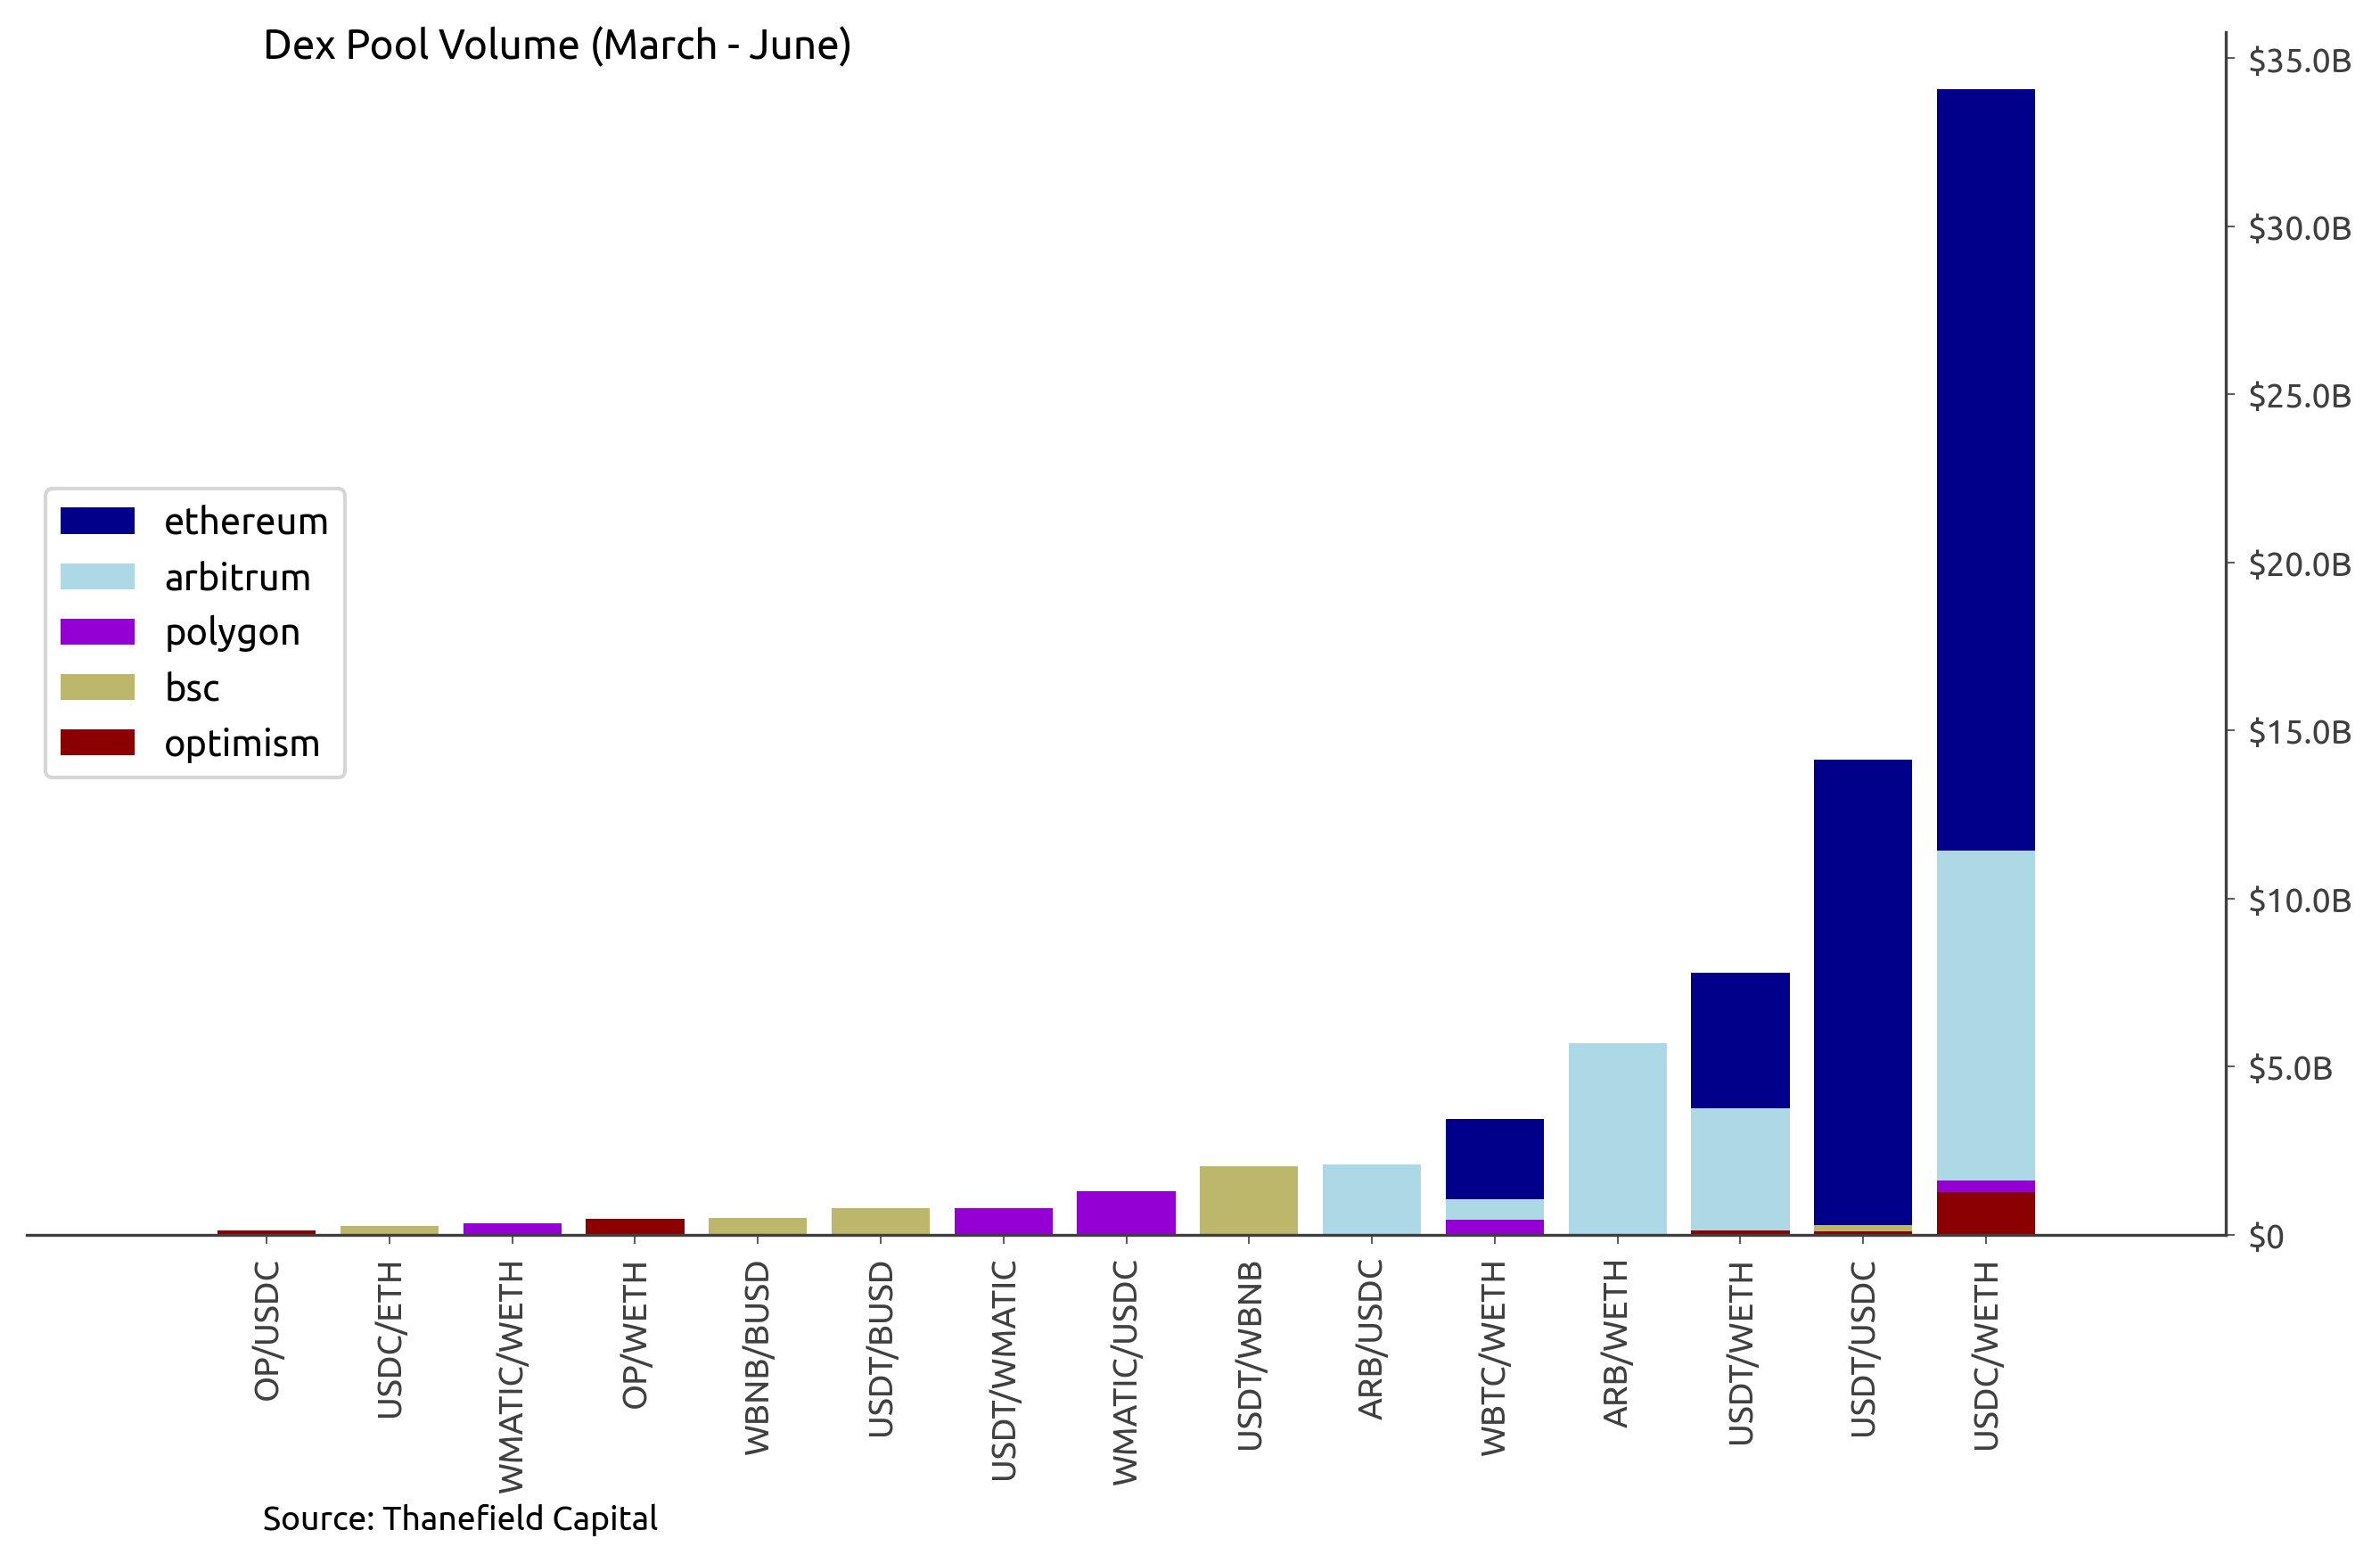

In [14]:
# note each token has over 1b volume
fig, ax = tc.chart('Dex Pool Volume (March - June)', dates=False)

ax.bar(pivot_df.index, pivot_df['ethereum'], color='darkblue', label='ethereum')
ax.bar(pivot_df.index, pivot_df['arbitrum'], color='lightblue', label='arbitrum')
ax.bar(pivot_df.index, pivot_df['polygon'], color='darkviolet', label='polygon')
ax.bar(pivot_df.index, pivot_df['bsc'], color='darkkhaki', label='bsc')
ax.bar(pivot_df.index, pivot_df['optimism'], color='darkred', label='optimism')

# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
# tc.legend(ax)
tc.set_xmargin(ax, margin=.05)
plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(loc='center left')

# save chart
tc.save('charts/dex_total_pool_vol.png')